In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
from torch import Tensor
import numpy as np
from enum import Enum
from typing import Final, List
import matplotlib.pyplot as plt
from abc import abstractmethod
from utils import *

In [3]:
class GROUP(Enum):
    Home = 0
    Draw = 1
    Away = 2

    def __str__(self) -> str:
        return self.name


In [4]:
class VisualizationHelper:

    WIDTH_BIAS : Final[int] = 1
    
    def __init__(self, t):
        self._tensor = t

    @abstractmethod
    def plot_height(self) -> int:
        raise NotImplementedError("This method is abstract!")
        
    @abstractmethod
    def plot_width(self, size : int) -> int:
        raise NotImplementedError("This method is abstract!")

    @abstractmethod
    def visualize_tensor(self, t : int) -> None:
        raise NotImplementedError("This method is abstract!")

    @property
    def tensor(self):
        return self._tensor
    
    @property
    def time(self) -> int:
        return self._time

In [5]:
class WinRateVHelper(VisualizationHelper):
    
    HEIGHT : Final[int] = 8
    MIN_WIDTH : Final[int] = 4
    WIDTH_DIVISOR : Final[int] = 6
    
    def __init__(self, t):
        super().__init__(t)
        self._time = t.size()[0]
        
    def plot_height(self) -> int:
        return self.HEIGHT

    def plot_width(self) -> int:
        return min(12, max(self.MIN_WIDTH, self.time // self.WIDTH_DIVISOR + self.WIDTH_BIAS))

    def convert_tensor(self, t, start : int, end : int) -> List[List[float]]:
        home : List[float] = []
        draw : List[float] = []
        away : List[float] = []
        for i in range(start, end):
            home.append(t[i,0].tolist())
            draw.append(t[i,1].tolist())
            away.append(t[i,2].tolist())
        return [home, draw, away]

    def own_calculate(self, a : float, b : float) -> float:
        if a == 0.0 and b == 0.0:
            return 0.0
        if a > 0.0 and b == 0.0:
            return 1.0
        if a < 0.0 and b == 0.0:
            return -1.0
        if a < b:
            return max(-1.0, (a - b) / b)
        else:
            return min(1.0, (a - b) / b)

    def calculate_change_rate(self, data : List[float], start : int, end : int) -> List[float]:
        if len(data) < 2:
            raise ArithmeticError
        fdata : List[float] = []
        fdata.append(0.0)
        for i in range(start + 1, end):
            fdata.append(self.own_calculate(data[i], data[i - 1]))
        return fdata
         
    def visualize_tensor_range(self, end : int, start : int = 0) -> None:
        if end < start:
            raise ArithmeticError
        if end > self.tensor.size()[0] - 1:
            end = self.tensor.size()[0] - 1
        if start > end - 100:
            start = max(0, end - 100)
        if start + 400 <= end:
            end = min(start + 399, self.tensor.size()[0] - 1)
        plt.figure(1, figsize=(self.plot_width(), self.plot_height()))
        plt.xticks(list(range(start, end + 10, 50)))
        plt.yticks(list(np.arange(0.0, 1.2, 0.1)))
        plt.plot(self.tensor[start: end + 1])
        plt.grid(True)
        plt.show()

    def visualize_tensor_range_label(self, end : int, start : int = 0) -> None:
        if end < start:
            raise ArithmeticError
        if end > self.tensor.size()[0] - 1:
            end = self.tensor.size()[0] - 1
        if start > end - 100:
            start = max(0, end - 100)
        if start + 400 <= end:
            end = min(start + 399, self.tensor.size()[0] - 1)
        data_g = self.convert_tensor(self.tensor, start, end + 1)
        plt.figure(1, figsize=(self.plot_width(), self.plot_height()))
        plt.xticks(list(range(start, end + 10, 50)))
        plt.yticks(list(np.arange(0.0, 1.2, 0.1)))
        plt.plot(data_g[0], label='Home')
        plt.plot(data_g[1], label='Draw')
        plt.plot(data_g[2], label='Away')
        plt.grid(True)
        plt.legend()
        plt.show()

    def visualize_tensor_range_label_change_rate(self, group : GROUP, end : int, start : int = 0) -> None:
        if end < start:
            raise ArithmeticError
        if end > self.tensor.size()[0] - 1:
            end = self.tensor.size()[0] - 1
        if start > end - 100:
            start = max(0, end - 100)
        if start + 400 <= end:
            end = min(start + 399, self.tensor.size()[0] - 1)
        predata = self.convert_tensor(self.tensor, start, end + 1)[group.value]
        data_g = self.calculate_change_rate(predata, start, end + 1)
        plt.figure(1, figsize=(self.plot_width(), self.plot_height()))
        plt.xticks(list(range(start, end + 10, 50)))
        plt.yticks(list(np.arange(-1.2, 1.3, 0.1)))
        plt.plot(data_g, label=group.__str__())
        plt.grid(True)
        plt.legend()
        plt.show()

In [6]:
class PlayerPositionVHelper(VisualizationHelper):
    
    MIN_WIDTH : Final[int] = 10
    MIN_HEIGHT : Final[int] = 10
    HEIGHT_DIVISOR : Final[int] = 52
    WIDTH_DIVISOR : Final[int] = 52
    
    def __init__(self, t, width : int, height : int):
        super().__init__(t)
        self._time = len(self.tensor)
        self._width = width
        self._height = height
        
    def plot_height(self) -> int:
        return min(14, max(self.MIN_HEIGHT, self.height // self.HEIGHT_DIVISOR + self.WIDTH_BIAS))
    
    def plot_width(self) -> int:
        return min(14, max(self.MIN_WIDTH, self.width // self.WIDTH_DIVISOR + self.WIDTH_BIAS))

    def visualize_tensor(self, t : int, show_pre : bool = False) -> None:
        if t < 0 or t >= self.time:
            raise ArithmeticError("@params time is out of bound!")
        plt.figure(1, figsize=(self.plot_width(), self.plot_height()))
        plt.xticks(list(range(0,self.width + 10, 20)))
        plt.yticks(list(range(0,self.height + 10, 20)))
        data_time = self.tensor[t]
        groupA = data_time[0]
        groupB = data_time[1]
        if show_pre and t > 0:
            data_time_pre = self.tensor[t - 1]
            groupAp = data_time_pre[0]
            groupBp = data_time_pre[1]
            plt.scatter(groupAp[0], groupAp[1], c = "red", s = 60, alpha=0.4)
            plt.scatter(groupBp[0], groupBp[1], c = "blue", s = 60, alpha=0.4)
        plt.scatter(groupA[0], groupA[1], c ="red", s = 60)
        plt.scatter(groupB[0], groupB[1], c ="blue", s = 60)
    
    @property
    def width(self) -> int:
        return self._width
    
    @property
    def height(self) -> int:
        return self._height

In [7]:
#Input the file that is going to be loaded
match_win_rate = torch.load("results/0.pt")
helper = WinRateVHelper(match_win_rate)

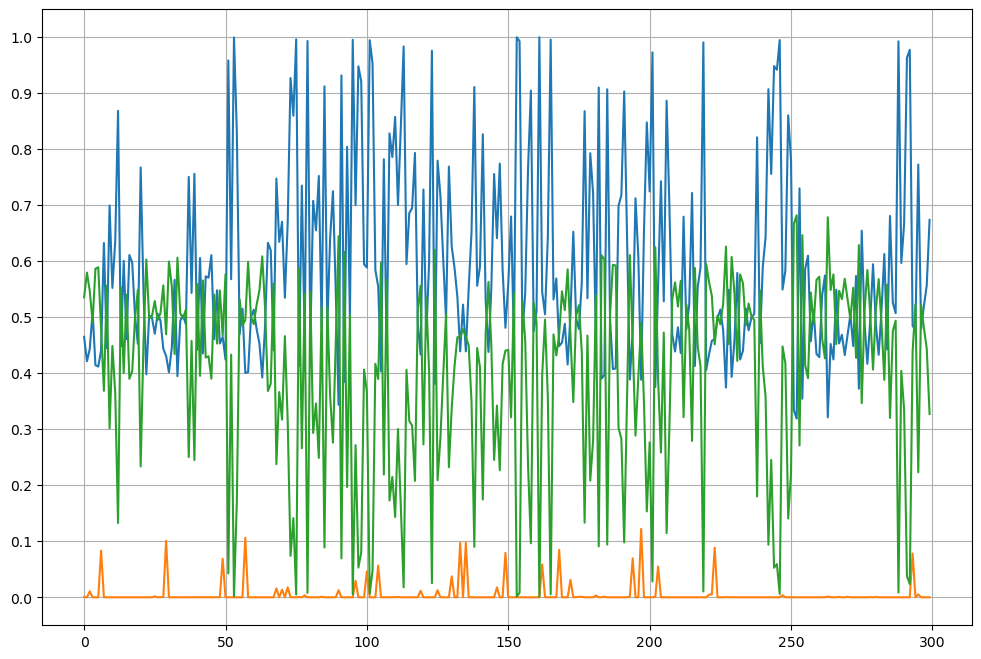

In [8]:
helper.visualize_tensor_range(end=299,start=0)

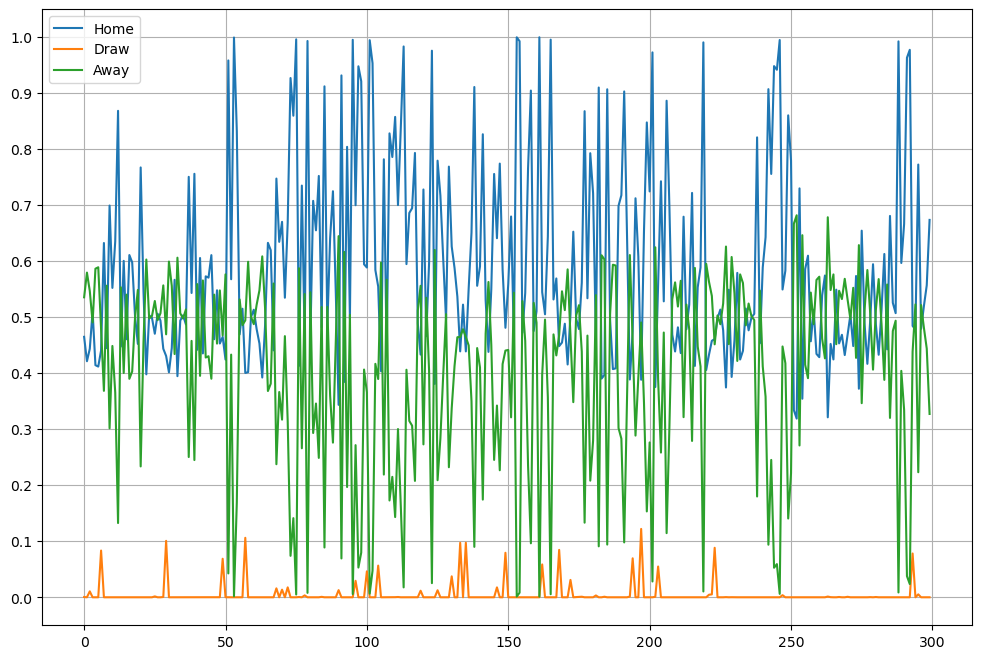

In [9]:
helper.visualize_tensor_range_label(end=299,start=0)

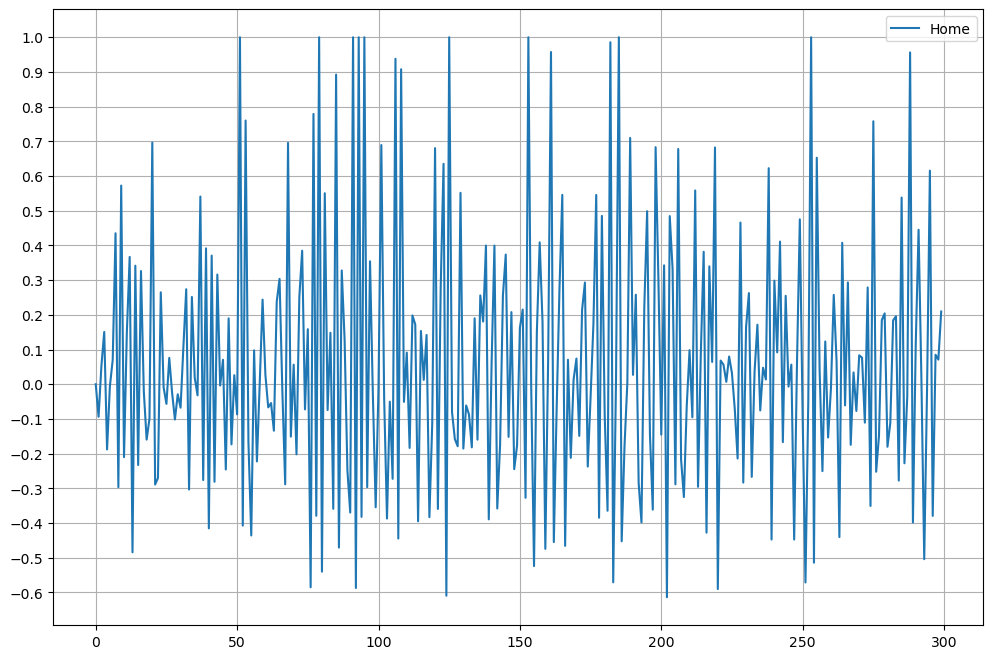

In [10]:
helper.visualize_tensor_range_label_change_rate(group=GROUP.Home, end=299,start=0)

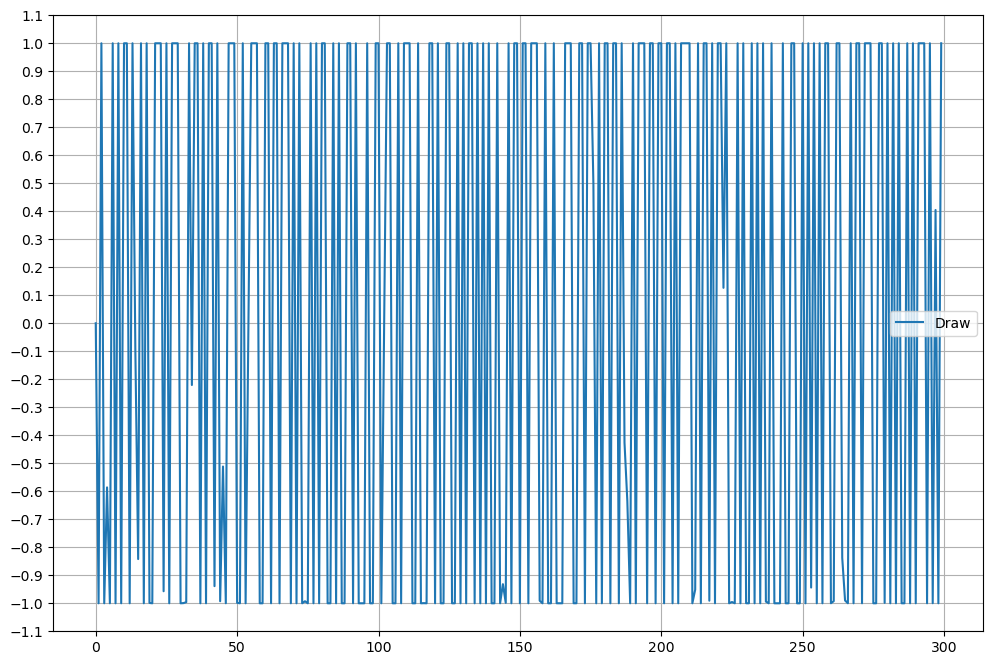

In [11]:
helper.visualize_tensor_range_label_change_rate(group=GROUP.Draw, end=299,start=0)

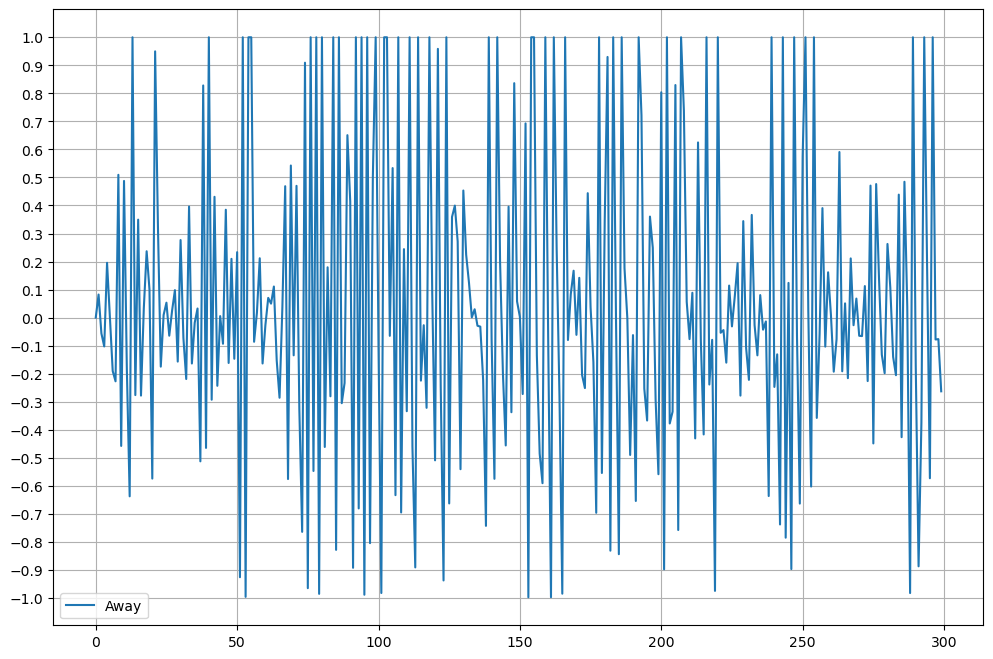

In [12]:
helper.visualize_tensor_range_label_change_rate(group=GROUP.Away, end=299,start=0)

In [13]:
# To show the position of player in a specific time
# filename = "name of the file"
# helper2 = PlayerPositionVHelper(Tensor(get_location_data(load_data(filename), 0)), 200, 200)

In [14]:
# helper2.visualize_tensor(2, True)